In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:

import os
current_directory = os.getcwd()
while current_directory.endswith("Notebooks"):
    os.chdir("..")
    current_directory = os.getcwd()
    print("Current working directory: ", current_directory)

In [ ]:
import pickle
from pathlib import Path
import torch
import numpy as np
import torch.nn as nn
from torch.optim import Adam
from torch.utils.data import DataLoader
from utils.filepaths.filepaths import FILE_PATH_TRANSIENT_TRAINING_DATA_102_TARGETS, FILE_PATH_TRANSIENT_TRAINING_DATA_102_FEATURES, FILE_PATH_TRANSIENT_TRAINING_DATA_101_FEATURES,FILE_PATH_TRANSIENT_TRAINING_DATA_101_TARGETS,FILE_PATH_TRANSIENT_TRAINING_DATA_102b_FEATURES, FILE_PATH_TRANSIENT_TRAINING_DATA_102b_TARGETS,FILE_PATH_TRANSIENT_OTHER_VARIABLES_101, FILE_PATH_TRANSIENT_OTHER_VARIABLES_102
from utils.models.models import MLP, LSTM
from utils.training.training import train_model_regression
from utils.datasets.datasets import MLPDataset

In [ ]:
with open(FILE_PATH_TRANSIENT_TRAINING_DATA_102_FEATURES, 'rb') as file:
    features_102 = pickle.load(file)
with open(FILE_PATH_TRANSIENT_TRAINING_DATA_102_TARGETS, 'rb') as file:
    targets_102 = pickle.load(file)
with open(FILE_PATH_TRANSIENT_TRAINING_DATA_101_FEATURES, 'rb') as file:
    features_101 = pickle.load(file)
with open(FILE_PATH_TRANSIENT_TRAINING_DATA_101_TARGETS, 'rb') as file:
    targets_101 = pickle.load(file)
# with open(FILE_PATH_TRANSIENT_TRAINING_DATA_102b_FEATURES, 'rb') as file:
#     features_102b = pickle.load(file)
# # with open(FILE_PATH_TRANSIENT_TRAINING_DATA_102b_TARGETS, 'rb') as file:
# #     targets_102b = pickle.load(file)
with open (FILE_PATH_TRANSIENT_OTHER_VARIABLES_101, 'rb') as file:
    other_variables_101= pickle.load(file)
with open (FILE_PATH_TRANSIENT_OTHER_VARIABLES_102, 'rb') as file:
    other_variables_102 = pickle.load(file)

In [ ]:
rng = np.random.default_rng()
features = np.concatenate((features_102, features_101), axis = 0)
targets = np.concatenate((targets_102, targets_101), axis = 0)
permutation = rng.permutation(len(features))
features = features[permutation]
targets = targets[permutation]

In [102]:
print(permutation)

[17 23  1 13 19  0 12  8  4 21  3 15  9 26 11 10 25 24  2 18 27 22 16 14
  7 20  6  5]


In [103]:
print(features.shape, targets.shape)

(28, 40, 6) (28, 40)


In [104]:
# Splitting datasets
training_features = features[:int(0.9 * len(features))]
validation_features = features[int(0.9 * len(features)):]

training_targets = targets[:int(0.9 * len(targets))]
validation_targets = targets[int(0.9 * len(targets)):]

In [105]:
# Normalizing
training_features = (training_features - training_features.mean(axis = (0,1))) / training_features.std(axis = (0,1)) 
validation_features = (validation_features - training_features.mean(axis = (0,1))) / training_features.std(axis = (0,1)) 

In [106]:
training_features = training_features.reshape(training_features.shape[0],features.shape[1]*features.shape[2])
validation_features = validation_features.reshape(validation_features.shape[0],features.shape[1]*features.shape[2])
print(training_features.shape, validation_features.shape)

(25, 240) (3, 240)


In [107]:
# Creating dataset class for the LSTM using MLP dataset class
train_data = MLPDataset(training_features, training_targets)
val_data = MLPDataset(validation_features,validation_targets)

In [108]:
# Dataloaders
batch_size =  2
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)


In [109]:
model = MLP(in_features=features.shape[1] * features.shape[2],hidden_size=256, out_features=40,task = "regression",dropout = 0.2)
# model = LSTM()

In [110]:
print(model(val_loader.dataset.features).shape)
print(val_loader.dataset.targets.shape)
train_loader.dataset.targets = train_loader.dataset.targets.squeeze(dim = -1)
val_loader.dataset.targets = val_loader.dataset.targets.squeeze(dim = -1)

torch.Size([3, 40])
torch.Size([3, 40, 1])


In [111]:
optimizer = Adam(model.parameters(), lr = 1e-1, weight_decay=1e-6)
criterion = nn.MSELoss()

In [112]:
path = Path("Notebooks")
train_loss, val_loss, best_model_path = train_model_regression(model = model, train_dataloader=train_loader, val_dataloader=val_loader, model_name = "test",criterion = criterion, optimizer=optimizer, num_epochs=1000, best_model_path=path)

Training...
Saving best model for epoch 1 with loss 421142986752.0000000
Saving best model for epoch 2 with loss 8165159680.0000000
Saving best model for epoch 3 with loss 2.8408675
Saving best model for epoch 4 with loss 2.4479530
Saving best model for epoch 5 with loss 2.3121105
Saving best model for epoch 6 with loss 2.2356675
Saving best model for epoch 7 with loss 2.1731349
Saving best model for epoch 8 with loss 2.1125863
Saving best model for epoch 9 with loss 2.0514158
Saving best model for epoch 10 with loss 2.0137096
Saving best model for epoch 11 with loss 1.9574117
Saving best model for epoch 12 with loss 1.8943144
Saving best model for epoch 13 with loss 1.8290071
Saving best model for epoch 14 with loss 1.7631146
Saving best model for epoch 15 with loss 1.6973490
Saving best model for epoch 16 with loss 1.6317929
Saving best model for epoch 17 with loss 1.5669687
Saving best model for epoch 18 with loss 1.5028509
Saving best model for epoch 19 with loss 1.4394752
Saving b

In [113]:
model.load_state_dict(torch.load(best_model_path))
preds = model(val_loader.dataset.features)

In [114]:
print(preds.shape)

torch.Size([3, 40])


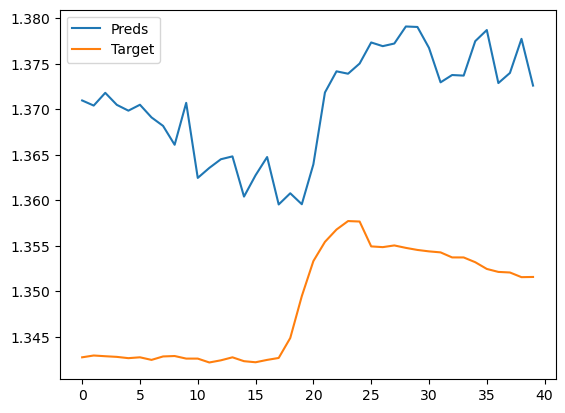

In [115]:
import matplotlib.pyplot as plt
plt.plot(preds[0,:].detach(), label = "Preds")
plt.plot(val_loader.dataset.targets[0],label = "Target")
plt.legend()
plt.show()

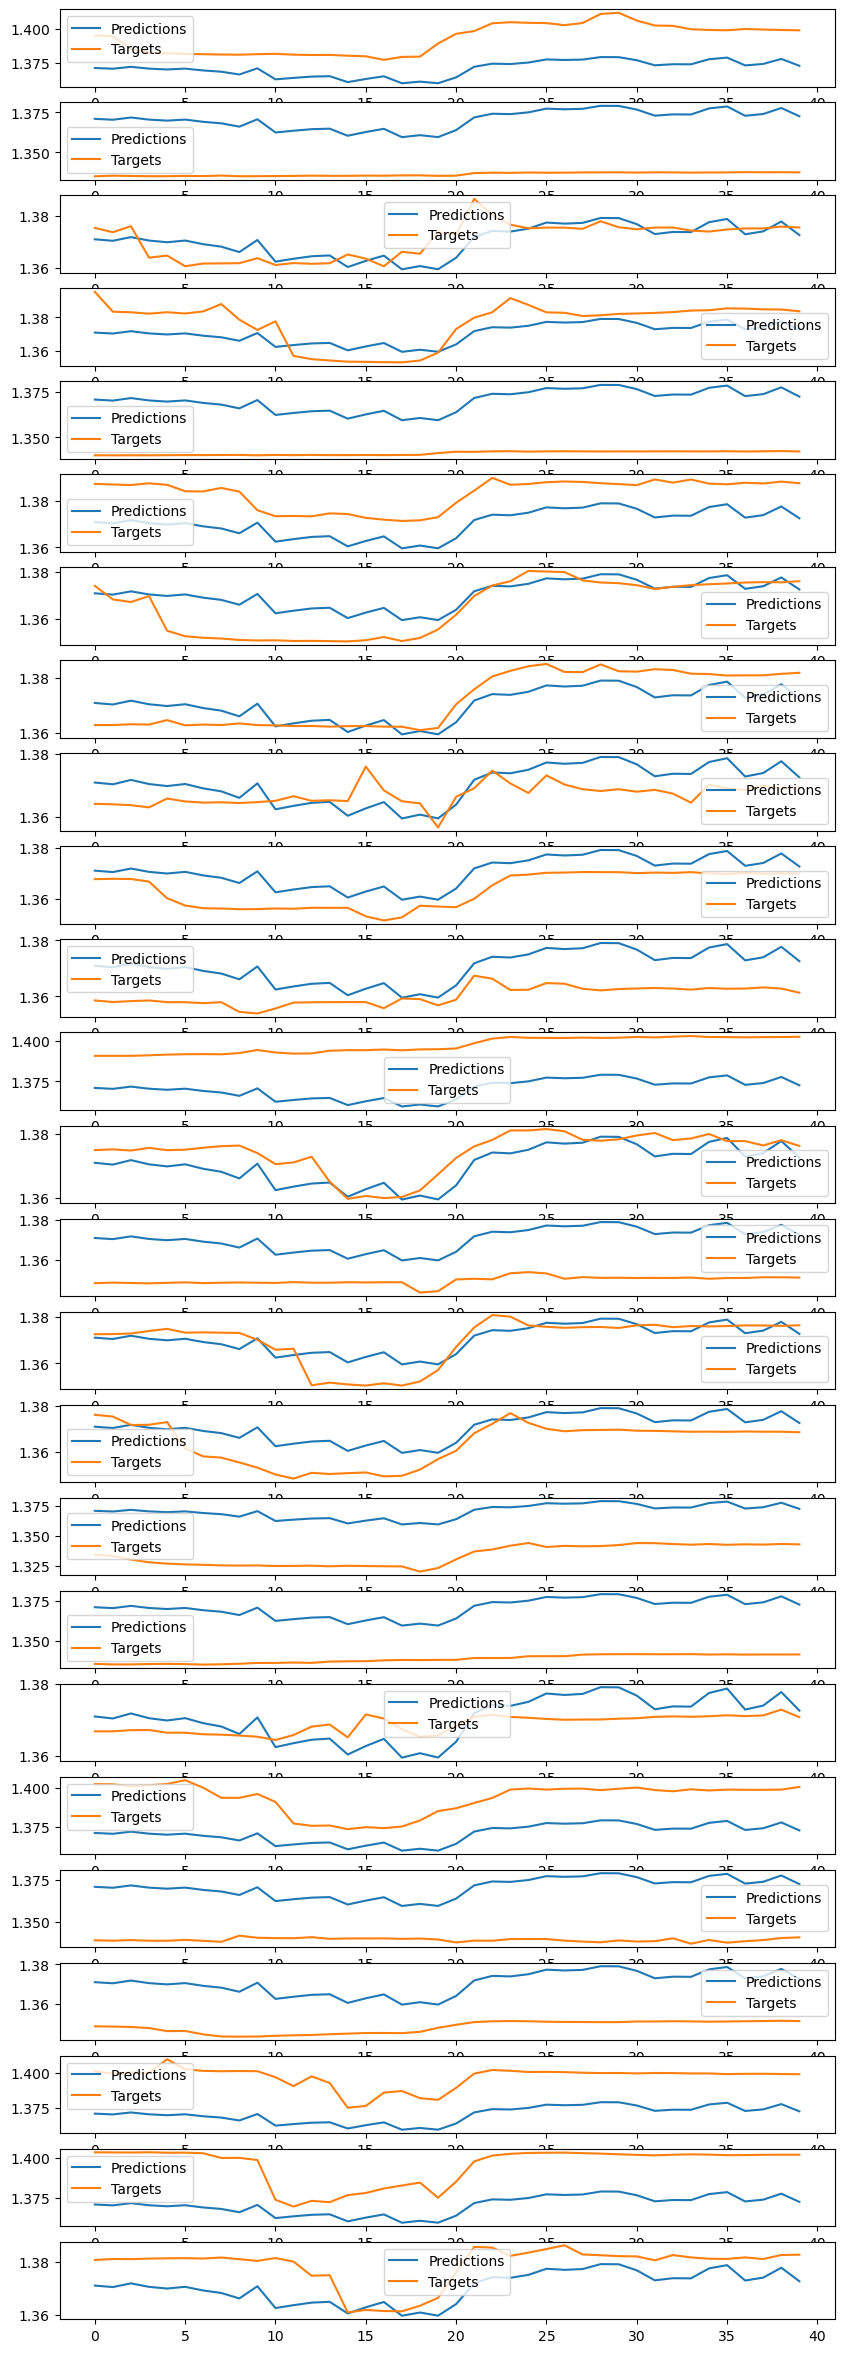

In [116]:
fig, ax = plt.subplots(len(train_loader.dataset.features), figsize = (10,30))
for subfig_idx in range(len(train_loader.dataset.features)):
    preds = model(train_loader.dataset.features[subfig_idx])
    ax[subfig_idx].plot(preds.detach(), label = "Predictions")
    ax[subfig_idx].plot(train_loader.dataset.targets[subfig_idx], label = "Targets")
    ax[subfig_idx].legend()

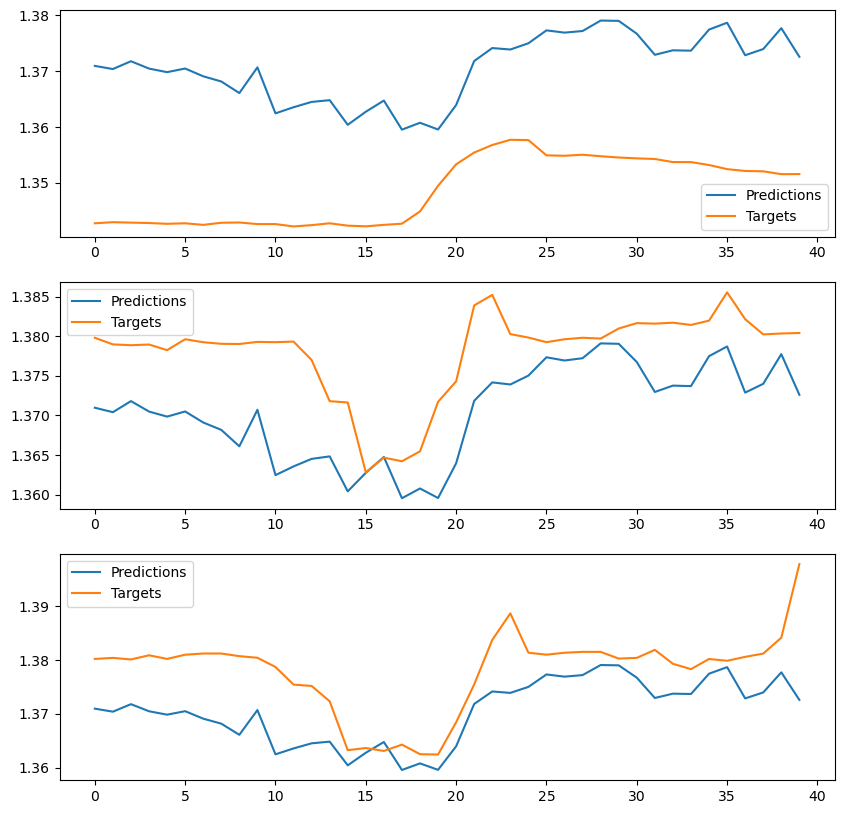

In [117]:

fig, ax = plt.subplots(len(val_loader.dataset.features), figsize = (10,10))
for subfig_idx in range(len(val_loader.dataset.features)):
    preds = model(val_loader.dataset.features[subfig_idx])
    ax[subfig_idx].plot(preds.detach(), label = "Predictions")
    ax[subfig_idx].plot(val_loader.dataset.targets[subfig_idx], label = "Targets")
    ax[subfig_idx].legend()